In [1]:
%%time
import pandas as pd
import os
import sys
from datetime import datetime
import numpy as np
import sqlite3
import nltk
import regex as re
import spacy
import json

from helper_functions import tokenise, get_contribution_windows, split_corpus, check_dir, make_tok_chunks, get_chunks
from mp_sampling import multi_mp_splits_with_limit, multi_mp_splits, get_end_of_windows
from run_CE_experiments import get_groups_toks_and_contribs

with open("../project-config.json") as config_file:
    project_config = json.load(config_file)

DB_FP = project_config["DB_FP"]
MP_Group_FP = project_config["GROUPS_FP"]
with open(project_config["SPEAKER_FILE"]) as speaker_file:
    speaker_list = json.load(speaker_file)

sql_get_all_posts ="""
SELECT c.uid, m.name, m.PimsId, p.party, d.date, c.body, c.topic, c.section, s.tmay_deal, s.benn_act, s.ref_stance, s.constituency_leave
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-12-11"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)));""".strip()

conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_contributions = pd.read_sql_query(sql_get_all_posts, conn)
all_contributions.columns = ['uid', 'name', 'PimsId', 'party', 'date', 'text', 'topic', 'section', 'tmay_deal', 'benn_act', 'ref_stance', 'constituency_leave']
all_contributions.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
all_contributions['date'] = all_contributions['date'].apply(convert_to_date)

all_contributions = all_contributions.query("PimsId not in @speaker_list")
all_contributions.sort_values("date", inplace=True)

# Tokenise the contributions
all_toks =  all_contributions["text"].apply(tokenise)

# Get the EU and Non-EU mentions
eu_mentions, non_eu_mentions = split_corpus(all_contributions, "eu")

# Keep only the tokens in the current contributions
all_toks = all_toks.loc[all_contributions.index]

Wall time: 2min 43s


In [2]:
from meta_analysis import get_meta, fix_ax
from matplotlib import pyplot as plt

def write_meta_files(curr_group_dir, contributions, tokens):
    check_dir(curr_group_dir)
    curr_dir = os.path.join(curr_group_dir, "all")
    get_meta(curr_dir, contributions, tokens, [0.5, 0.75, 0.95])
    plot_cum_contribs_and_words(contributions, tokens, curr_dir)

    curr_subset, curr_ref = split_corpus(contributions, "EU")
    curr_sub_toks = tokens.loc[curr_subset.index]
    curr_ref_toks =  tokens.loc[curr_ref.index]

    curr_dir = os.path.join(curr_group_dir, "EU")
    get_meta(curr_dir, curr_subset, curr_sub_toks, [0.5, 0.75, 0.95])
    plot_cum_contribs_and_words(curr_subset, curr_sub_toks, curr_dir)

    curr_dir = os.path.join(curr_group_dir, "Non-EU")
    get_meta(curr_dir, curr_ref, curr_ref_toks, [0.5, 0.75, 0.95])
    plot_cum_contribs_and_words(curr_ref, curr_ref_toks, curr_dir)


def cum_plot(data, out_fp, ylabel=""):
    fig, ax = plt.subplots(figsize=(10, 10))
    cum = data.cumsum()
    cum.plot(ax=ax, label="all", grid=True)
    ax.set_xlabel("")
    ax.set_ylabel(ylabel, fontsize=14)
    plt.setp(ax.get_xticklabels(), fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    fig.savefig(out_fp)
    

def plot_cum_contribs_and_words(contribs, toks, curr_dir):
    # plot cumulative contributions and words
    cum_contributions = contribs.groupby("date").size()
    cum_plot(cum_contributions, os.path.join(curr_dir, "cumulative_contribs.pdf"), "Cumulative Num Contributions")

    cum_words = toks.apply(len).groupby(contribs.date).sum()
    cum_plot(cum_words, os.path.join(curr_dir, "cumulative_words.pdf"), "Cumulative Num Words")
    

def group_meta_plot(contribs):
    curr_toks = self.tokenised["tokens"].loc[contribs.index]
    curr_contribs = contribs.loc[curr_toks.index]
    self.write_meta_files(curr_group_dir, curr_contribs, curr_toks)
    
    
def run_meta_analysis(contributions, toks, meta_dir):
    curr_dir = os.path.join(meta_dir, "All_Groups")
    write_meta_files(curr_dir, contributions, toks)
    
    # Close all figures
    plt.close("all")

    # Meta info for Conservative
    cur = contributions.query("party == 'Conservative'")
    cur_toks = toks.loc[cur.index]
    write_meta_files(os.path.join(meta_dir, "Conservative"), cur, cur_toks)
    # Close all figures
    plt.close("all")
    
    # Meta info for Labour
    cur = contributions.query("party == 'Labour'")
    cur_toks = toks.loc[cur.index]
    write_meta_files(os.path.join(meta_dir, "Labour"), cur, cur_toks)    
    # Close all figures
    plt.close("all")
    
    # Meta info for Remain
    cur = contributions.query("ref_stance == 'remain'")
    cur_toks = toks.loc[cur.index]
    write_meta_files(os.path.join(meta_dir, "Remain"), cur, cur_toks)
    # Close all figures
    plt.close("all")
    
    # Meta info for Leave
    cur = contributions.query("ref_stance == 'leave'")
    cur_toks = toks.loc[cur.index]
    write_meta_files(os.path.join(meta_dir, "Leave"), cur, cur_toks)
    # Close all figures
    plt.close("all")
    

In [3]:
from importlib import reload
import meta_analysis
reload(meta_analysis)
from meta_analysis import get_meta

In [4]:
%%time
run_meta_analysis(all_contributions, all_toks, "C:/Users/Eddie/Documents/Datasets/Hansard Output/Test Meta")

Wall time: 2min 31s


# Make Cumulative Plot for Each Group

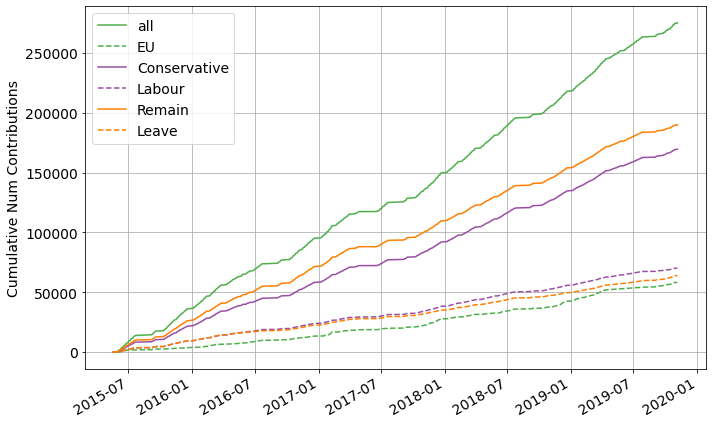

In [5]:
from cycler import cycler

fig, ax = plt.subplots(figsize=(10, 6))

colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33"]

graph_cycler = (cycler(color=["#4daf4a", "#984ea3", "#ff7f00"]) *
                cycler(linestyle=['-', '--']))

ax.set_prop_cycle(graph_cycler)

# All contributions
cum_contributions = all_contributions.groupby("date").size().cumsum()
cum_contributions.plot(ax=ax, label="all", grid=True)

# EU Mentions
cum_contributions = eu_mentions.groupby("date").size().cumsum()
cum_contributions.plot(ax=ax, label="EU", grid=True)

# Conservative
cum_contributions = all_contributions.query("party == 'Conservative'").groupby("date").size().cumsum()
cum_contributions.plot(ax=ax, label="Conservative", grid=True)

# Labour
cum_contributions = all_contributions.query("party == 'Labour'").groupby("date").size().cumsum()
cum_contributions.plot(ax=ax, label="Labour", grid=True)

# Remain
cum_contributions = all_contributions.query("ref_stance == 'remain'").groupby("date").size().cumsum()
cum_contributions.plot(ax=ax, label="Remain", grid=True)

# Leave
cum_contributions = all_contributions.query("ref_stance == 'leave'").groupby("date").size().cumsum()
cum_contributions.plot(ax=ax, label="Leave", grid=True)

ax.set_xlabel("")
ax.set_ylabel("Cumulative Num Contributions", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
ax.legend(fontsize=14)

fig.savefig(os.path.join("C:/Users/Eddie/Documents/Datasets/Hansard Output/Test Meta", "cumulative_contribs.pdf"))
plt.show()

In [6]:
from helper_functions import get_time_windows

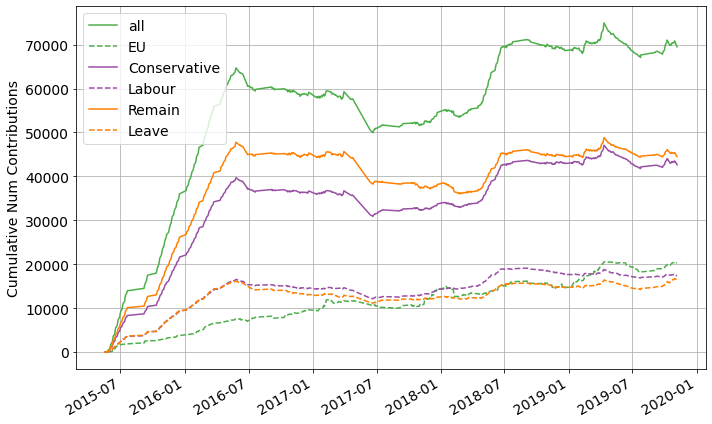

In [7]:
from cycler import cycler

fig, ax = plt.subplots(figsize=(10, 6))

colour_list = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33"]

graph_cycler = (cycler(color=["#4daf4a", "#984ea3", "#ff7f00"]) *
                cycler(linestyle=['-', '--']))

ax.set_prop_cycle(graph_cycler)

window_size = "365d"

# All contributions
all_contributions.groupby("date").size().rolling(window_size).sum().plot(ax=ax, label="all", grid=True)

# EU Mentions
eu_mentions.groupby("date").size().rolling(window_size).sum().plot(ax=ax, label="EU", grid=True)

# Conservative
curr = all_contributions.query("party == 'Conservative'")
curr.groupby("date").size().rolling(window_size).sum().plot(ax=ax, label="Conservative", grid=True)

# Labour
curr = all_contributions.query("party == 'Labour'")
curr.groupby("date").size().rolling(window_size).sum().plot(ax=ax, label="Labour", grid=True)

# Remain
curr = all_contributions.query("ref_stance == 'remain'")
curr.groupby("date").size().rolling(window_size).sum().plot(ax=ax, label="Remain", grid=True)

# Leave
curr = all_contributions.query("ref_stance == 'leave'")
curr.groupby("date").size().rolling(window_size).sum().plot(ax=ax, label="Leave", grid=True)

ax.set_xlabel("")
ax.set_ylabel("Cumulative Num Contributions", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)
ax.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
ax.legend(fontsize=14)

# fig.savefig(os.path.join("C:/Users/Eddie/Documents/Datasets/Hansard Output/Test Meta", "cumulative_contribs.pdf"))
plt.show()

# Print Top MPs

In [8]:
sql_get_member_post_counts ="""
SELECT m.name, COUNT(c.uid) as c_count, p.party, s.ref_stance, s.constituency_leave
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-09-10"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)))
GROUP BY c.member;""".strip()

In [9]:
%%time
# Gets all the contributions and creates a nice dataframe
member_post_counts = pd.read_sql_query(sql_get_member_post_counts, conn)
member_post_counts.columns = ['Name', '# Contribs', 'Party', 'Referendum Stance', 'Constituency Leave %']
member_post_counts.set_index("Name", inplace=True)

Wall time: 1.05 s


In [36]:
mp_table = member_post_counts.sort_values("# Contribs", ascending=False).head(10)
mp_table.to_csv(os.path.join("C:/Users/Eddie/Documents/Datasets/Hansard Output/Test Meta", "mp_table.csv"))
mp_table

,# Contribs,Party,Referendum Stance,Constituency Leave %
Name,,,,
John Bercow,11204,Speaker,unknown,48.9
Mrs Theresa May,7812,Conservative,remain,45.0
Andrea Leadsom,3985,Conservative,leave,53.3
Chris Grayling,3474,Conservative,leave,47.8
Sajid Javid,2652,Conservative,remain,55.4
Sir David Lidington,2505,Conservative,remain,51.8
Mr David Cameron,2269,Conservative,remain,46.3
Mr Jeremy Hunt,2153,Conservative,remain,40.7
Greg Clark,1979,Conservative,remain,44.6


In [37]:
print("N Contribs: ", mp_table["# Contribs"].sum())

N Contribs:  39732


In [20]:
top_50_mps = member_post_counts.sort_values("# Contribs", ascending=False).head(50)

In [35]:
print("N Contribs: ", top_50_mps["# Contribs"].sum())
print("N Leave   : ", top_50_mps.query("`Referendum Stance` == 'leave'").shape[0])
print("N Labour  : ", top_50_mps.query("Party == 'Labour'").shape[0])
print("N R Con   : ", top_50_mps.query("`Constituency Leave %` < 50").shape[0])

N Contribs:  85722
N Leave   :  11
N Labour  :  4
N R Con   :  21


# Make Stats Tables

In [11]:
def make_meta_table(contributions, tokens):
    n_contribs = len(contributions)
    n_users = len(contributions["PimsId"].unique())

    post_lengths = tokens.apply(len)

    contribs_per_user = contributions.groupby("PimsId").size()

    words_per_user = post_lengths.groupby(contributions["PimsId"]).sum()
    
    return {"Number of Posts": n_contribs, 
            "Number of Words": post_lengths.sum(), 
            "Number of MPs": n_users, 
            "Users w/ >50 Contributions": len(contribs_per_user[contribs_per_user > 50]), 
            "Median Words/Contribution": post_lengths.median(), 
            "Median Words/MP": words_per_user.median(), 
            "Median Contributions/MP": contribs_per_user.median()}

In [12]:
meta_table = pd.DataFrame({name: make_meta_table(contribs, all_toks.loc[contribs.index]) 
                 for name, contribs in zip(["All", "EU Mentions"],
                                           [all_contributions, eu_mentions])})

meta_table.to_csv(os.path.join("C:/Users/Eddie/Documents/Datasets/Hansard Output/Test Meta", "basic_meta.csv"))

In [13]:
meta_table

,All,EU Mentions
Number of Posts,275124.0,58234.0
Number of Words,50722777.0,13616779.0
Number of MPs,749.0,743.0
Users w/ >50 Contributions,709.0,291.0
Median Words/Contribution,90.0,102.0
Median Words/MP,50803.0,10135.0
Median Contributions/MP,253.0,36.0


In [14]:
meta_table = pd.DataFrame({name: make_meta_table(contribs, all_toks.loc[contribs.index]) 
                 for name, contribs in zip(["Conservative", "Labour", "Remain", "Leave"],
                                           [all_contributions.query("party == 'Conservative'"), 
                                            all_contributions.query("party == 'Labour'"), 
                                            all_contributions.query("ref_stance == 'remain'"), 
                                            all_contributions.query("ref_stance == 'leave'")])})

meta_table.to_csv(os.path.join("C:/Users/Eddie/Documents/Datasets/Hansard Output/Test Meta", "group_meta.csv"))

In [15]:
meta_table

,Conservative,Labour,Remain,Leave
Number of Posts,169568.0,70178.0,189926.0,64046.0
Number of Words,28097807.0,15228921.0,35917059.0,10696605.0
Number of MPs,363.0,288.0,477.0,156.0
Users w/ >50 Contributions,352.0,263.0,456.0,148.0
Median Words/Contribution,88.0,94.0,92.0,86.0
Median Words/MP,56571.0,43954.5,61980.0,48520.5
Median Contributions/MP,312.0,203.0,293.0,275.0
